In [73]:
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
device = torch.device('cuda')
aggregation_method = 'min'

# SAMPLE VAL DATA

In [46]:
grad_relative_path = '../../'

In [47]:
# # load sgd gradients of ref points
# ref_grads = torch.load(grad_relative_path + 'grads/TinyLlama/TinyLlama-1.1B-Chat-v1.0-p0.1-lora-seed3/mmlu-ckpt92-sgd/dim8192/all_orig.pt')
# if not torch.is_tensor(ref_grads):
#     ref_grads = torch.tensor(ref_grads)
# ref_grads = ref_grads.to(device).float()
# # load adam gradients of val points
# val_grads = torch.load(grad_relative_path + 'grads/TinyLlama/TinyLlama-1.1B-Chat-v1.0-p0.1-lora-seed3/fake_val/dolly-ckpt92-adam/dim8192/all_orig.pt')
# if not torch.is_tensor(val_grads):
#     val_grads = torch.tensor(val_grads)
# val_grads = val_grads.to(device).float()
# print(ref_grads.shape, val_grads.shape)
# def sample_tensor(tensor, sample_fraction=0.2, seed=0): 
#     torch.manual_seed(seed)
#     num_samples = int(tensor.size(0) * sample_fraction)
#     indices = torch.randperm(tensor.size(0))[:num_samples]
#     return tensor[indices], indices

# sampled_val_grads, sampled_indices = sample_tensor(val_grads, 0.2, seed=0) # sampled_indices is the indices of samples from the original file
# print(sampled_val_grads.shape)

# COS

In [ ]:
N_SUBTASKS = {"mmlu": 57, "bbh": 27, "tydiqa": 9}
from typing import List
grad_relative_path = '../../'
def calculate_influence_score(training_info: torch.Tensor, validation_info: torch.Tensor):
    """Calculate the influence score.

    Args:
        training_info (torch.Tensor): training info (gradients/representations) stored in a tensor of shape N x N_DIM
        validation_info (torch.Tensor): validation info (gradients/representations) stored in a tensor of shape N_VALID x N_DIM
    """
    # N x N_VALID
    influence_scores = torch.matmul(
        training_info, validation_info.transpose(0, 1))
    return influence_scores
def aggregate_influence_scores(influence_scores: torch.Tensor, method: str = "mean"):
    """Aggregate the influence scores.

    Args:
        influence_scores (torch.Tensor): influence scores stored in a tensor of shape N x N_TASK X N_VALID
        aggregation (str): aggregation method, one of "mean", "max", "min"
    """
        #   influence_score = influence_score.reshape(
        #             influence_score.shape[0], N_SUBTASKS[target_task_name], -1).mean(-1).max(-1)[0]
    if method == "mean":
        return influence_scores.mean(-1)
    elif method == "max":
        return influence_scores.max(-1)[0]
    elif method == "min":
        return influence_scores.min(-1)[0]
    else:
        raise ValueError("Invalid aggregation method.")
def get_inf_scores(checkpoint_weights: List[str], target_task_names: List[str], train_file_names: List[str], ckpts: List[float], 
                   validation_gradient_path: str, gradient_path: str, output_path: str, aggregation_method: str = "mean"):
    # renormalize the checkpoint weights
    if sum(checkpoint_weights) != 1:
        s = sum(checkpoint_weights)
        checkpoint_weights = [i/s for i in checkpoint_weights]

    # calculate the influence score for each validation task
    for target_task_name in target_task_names:
        for train_file_name in train_file_names:
            influence_score = 0
            for i, ckpt in enumerate(ckpts):
                # validation_path = validation_gradient_path.format(
                # target_task_name, ckpt)
                validation_path = validation_gradient_path.format(
                    ckpt, target_task_name)
                if os.path.isdir(validation_path):
                    validation_path = os.path.join(validation_path, "all_orig.pt")
                validation_info = torch.load(validation_path)

                if not torch.is_tensor(validation_info):
                    validation_info = torch.tensor(validation_info)
                validation_info = validation_info.to(device).float()
                # gradient_path = gradient_path.format(train_file_name, ckpt)
                gradient_path = gradient_path.format(ckpt, train_file_name)
                if os.path.isdir(gradient_path):
                    gradient_path = os.path.join(gradient_path, "all_orig.pt")
                training_info = torch.load(gradient_path)

                if not torch.is_tensor(training_info):
                    training_info = torch.tensor(training_info)
                training_info = training_info.to(device).float()

                influence_score += checkpoint_weights[i] * \
                    calculate_influence_score(
                        training_info=training_info, validation_info=validation_info)
                print("Finished calculating influence score at checkpoint {}".format(ckpt))
            influence_score = influence_score.reshape(
                influence_score.shape[0], N_SUBTASKS[target_task_name], -1)
            
            influence_score = aggregate_influence_scores(influence_score, method=aggregation_method).max(-1)[0]
            output_dir = os.path.join(output_path, target_task_name)
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            output_file = os.path.join(
                output_path, target_task_name, f"{train_file_name}_{aggregation_method}_influence_score.pt")
            torch.save(influence_score, output_file)
            print("Saved influence score to {}".format(output_file))


In [49]:
get_inf_scores(
    checkpoint_weights=[1.707865168539327e-05,1.2808988764044946e-05,7.528089887640449e-06,2.4719101123595505e-06], 
    target_task_names=["mmlu"], 
    train_file_names=['dolly'],
    ckpts=[23, 46, 70, 92], 
    gradient_path=grad_relative_path + 'grads/TinyLlama/TinyLlama-1.1B-Chat-v1.0-p0.1-lora-seed3/fake_val/dolly-ckpt{}-adam/dim8192', 
    validation_gradient_path=grad_relative_path + 'grads/TinyLlama/TinyLlama-1.1B-Chat-v1.0-p0.1-lora-seed3/mmlu-ckpt{}-sgd/dim8192', 
    output_path='selected_data',
    aggregation_method=aggregation_method)

Finished calculating influence score at checkpoint 23
Finished calculating influence score at checkpoint 46
Finished calculating influence score at checkpoint 70
Finished calculating influence score at checkpoint 92
Saved influence score to selected_data/mmlu/dolly_mean_influence_score.pt


In [50]:
# grads_cos = calculate_cosine_similarity(sampled_val_grads, ref_grads)
# grads_cos.shape

In [51]:
# mean_cos = grads_cos.mean(-1)
# mean_cos.shape

## Apply 

# THRESHOLD

In [74]:
file_path = f'selected_data/mmlu/dolly_{aggregation_method}_influence_score.pt'
inf_scores = torch.load(file_path)
inf_scores.shape

torch.Size([1000])

In [75]:
sorted_inf_scores, _ = torch.sort(inf_scores)
sorted_inf_scores.shape
# sorted_mean_cos, _ = torch.sort(mean_cos)
# print(sorted_mean_cos)


torch.Size([1000])

In [76]:
n_samples = sorted_inf_scores.size(0)
chunk_size = n_samples // 3
low_threshold = sorted_inf_scores[chunk_size]
high_threshold = sorted_inf_scores[2 * chunk_size]
print(low_threshold, high_threshold)

tensor(-0.0021, device='cuda:0') tensor(0.0046, device='cuda:0')


# Distribution

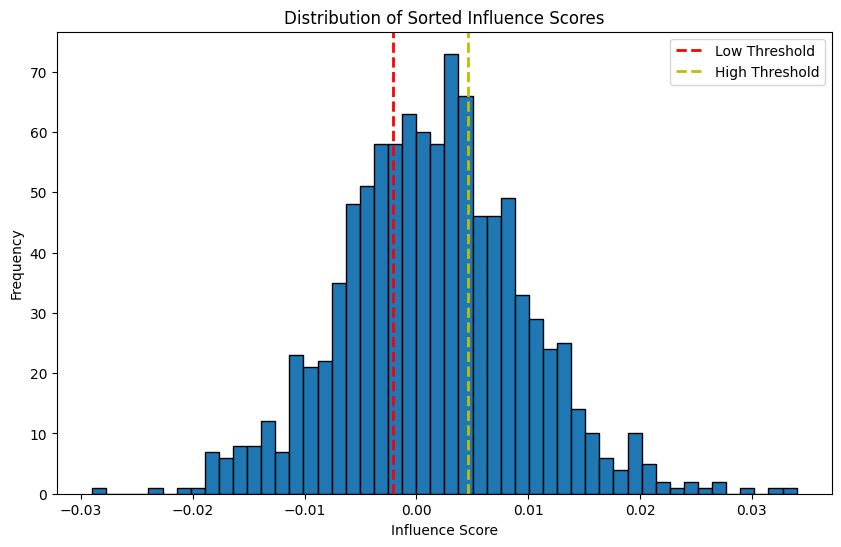

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(sorted_inf_scores.cpu().numpy(), bins=50, edgecolor='black')
plt.title('Distribution of Sorted Influence Scores')
plt.xlabel('Influence Score')
plt.ylabel('Frequency')
# plt.show()
plt.axvline(low_threshold.cpu().item(), color='r', linestyle='dashed', linewidth=2, label='Low Threshold')
plt.axvline(high_threshold.cpu().item(), color='y', linestyle='dashed', linewidth=2, label='High Threshold')
plt.legend()

# Label

In [56]:
labels = torch.empty_like(inf_scores, dtype=torch.long)

labels[inf_scores < low_threshold] = 0
labels[(inf_scores >= low_threshold) & (inf_scores < high_threshold)] = 1
labels[inf_scores >= high_threshold] = 2

# print(labels)
labels.shape

torch.Size([1000])

In [57]:
labels[:5]

tensor([2, 2, 2, 1, 1], device='cuda:0')

# Save (Text, Grad, Label)

In [58]:
from datasets import load_dataset
from typing import Union, List

def load_raw_dataset(train_files: Union[List[str], str]):
    """ load raw dataset """
    if isinstance(train_files, str):
        train_files = [train_files]
    processed_datasets = load_dataset(
        "json",
        data_files=train_files,
    )["train"]
    return processed_datasets

In [59]:
text_path = '../data/train/processed/dolly/sampled_val_dolly_data.jsonl'
texts = load_raw_dataset(text_path)

In [60]:
import json

with open(f'../data/filter/dolly/{aggregation_method}_all.jsonl', 'w', encoding='utf-8') as file:
    for text, inf_score, label in zip(texts, inf_scores, labels):
        data = {
            "text": text,
            "cos": inf_score.item(),
            "label": label.item()
        }
        file.write(json.dumps(data, ensure_ascii=False) + '\n')


In [61]:
inf_scores[0]

tensor(0.0209, device='cuda:0')

In [62]:
labels[0]

tensor(2, device='cuda:0')